In [ ]:
import sys
sys.path.append('../src')

In [2]:
import common.config as cfg
from common.nb_utils import estimate_optimal_ncomponents, pca_transform
from common.utils import get_device, Struct
from data.loader import get_testloader, get_trainloader
import matplotlib.pyplot as plt
from models.fcn import FCN
from models.resnet import resnet18
from models.model_op import weights_init
from models.svm import SVM
import models.resnet as resnet
import numpy as np
import pickle as pkl
import seaborn as sns
import torch as t
import time
from tqdm.notebook import tqdm

In [3]:
dataset = 'mnist'
input_size = cfg.input_sizes[dataset]
output_size = cfg.output_sizes[dataset]
lr = 1e-1
sdirs_algo = 'pca' # 'qr'
bs = 256
epochs = 10

In [4]:
device = t.device('cuda:1')
loss = t.nn.CrossEntropyLoss().to(device)

In [5]:
trainloader = get_trainloader(dataset, bs, True)
testloader = get_testloader(dataset, bs, True)

# pretraining

In [6]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

correcti = 0
x_test = 0
for idx, (data, labels) in enumerate(testloader):
    x, y = data.to(device), labels.to(device)
    y_hat = model(x)
    loss_val = loss(y_hat, y)
    predi = y_hat.argmax(1, keepdim=True)
    correcti += predi.eq(y.view_as(predi)).sum().item()
y_test = correcti/len(testloader.dataset)
x_test, y_test

(0, 0.1077)

# Just SGD

In [7]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xb_train, yb_train = [], []
xb_test, yb_test =[], []
print('epoch \t val_loss \t val_acc \t train_acc')
for _ in tqdm(range(1, epochs+1), leave=False):
    xb_train.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xb_train[-1], loss_val.item(), yb_test[-1], yb_train[-1],
    ))

epoch 	 val_loss 	 val_acc 	 train_acc


1 	 0.4175 	 0.98 	 0.96
2 	 0.0007 	 0.99 	 0.99
3 	 0.0376 	 0.99 	 0.99
4 	 0.1553 	 0.99 	 1.00
5 	 0.0019 	 0.99 	 1.00
6 	 0.0228 	 0.99 	 1.00
7 	 0.0010 	 0.99 	 1.00
8 	 0.0000 	 0.99 	 1.00
9 	 0.0087 	 0.99 	 1.00
10 	 0.1788 	 0.99 	 1.00


# Model Updates

In [8]:
orig = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
orig.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

<All keys matched successfully>

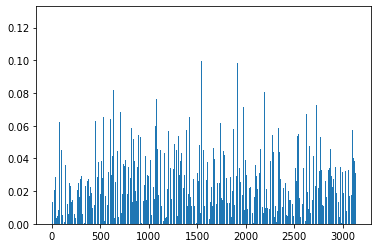

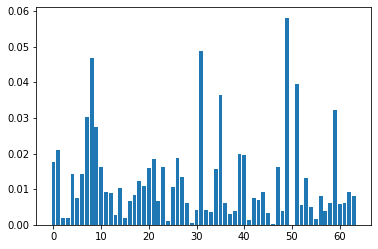

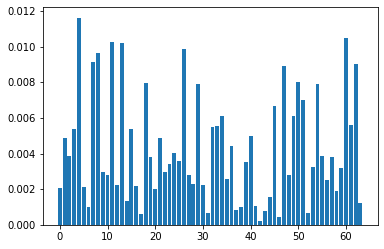

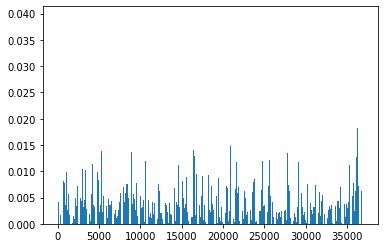

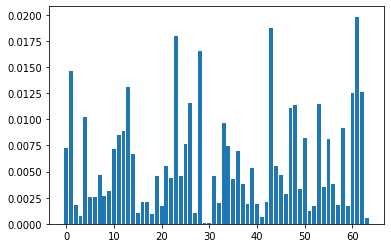

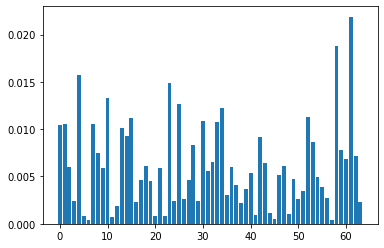

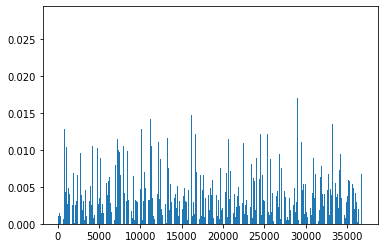

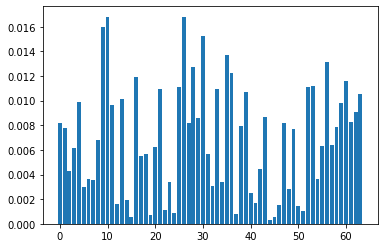

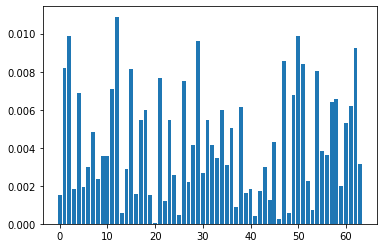

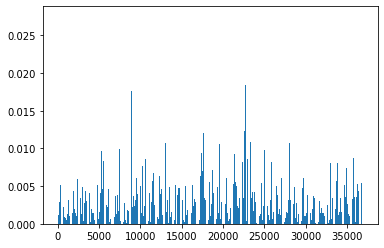

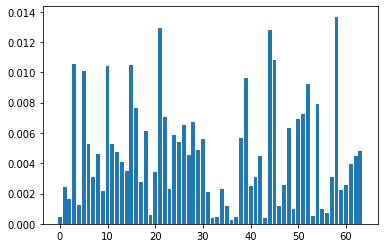

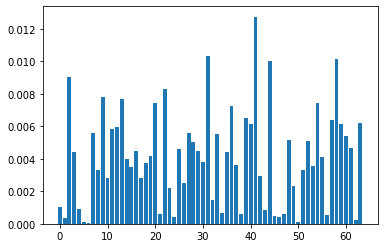

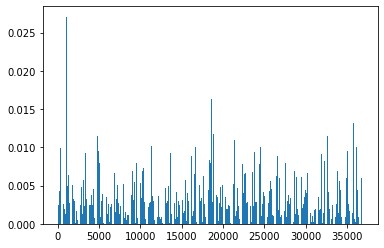

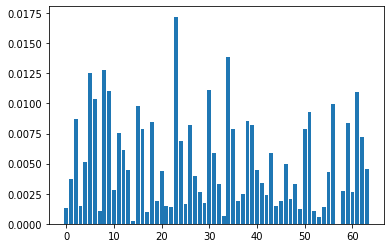

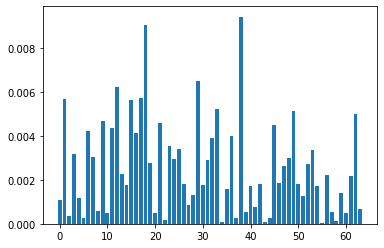

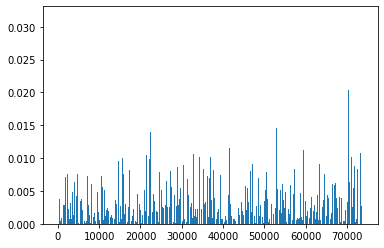

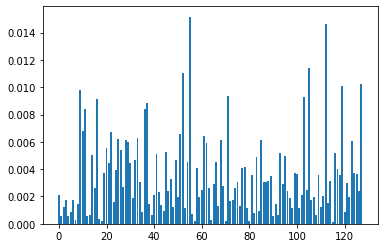

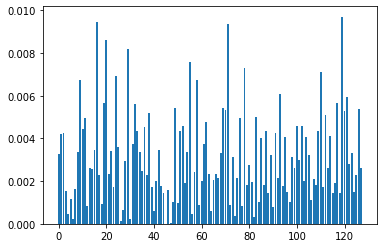

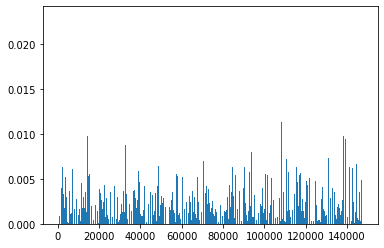

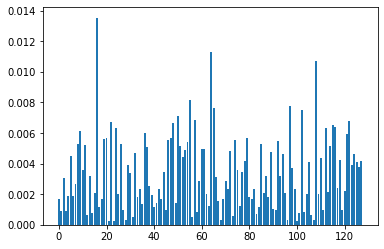

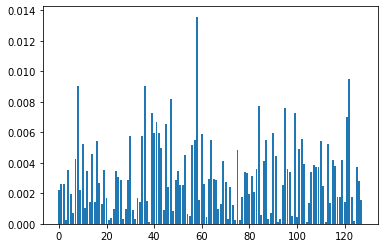

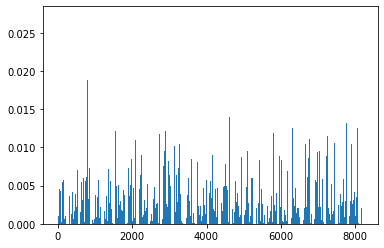

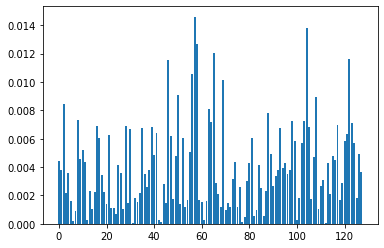

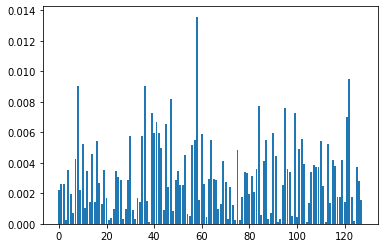

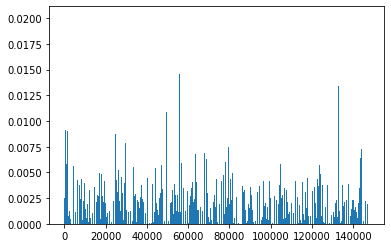

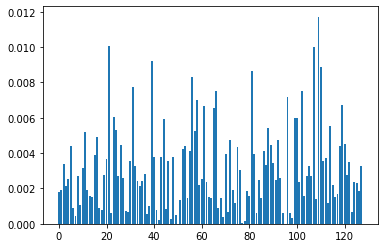

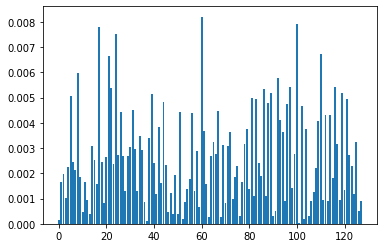

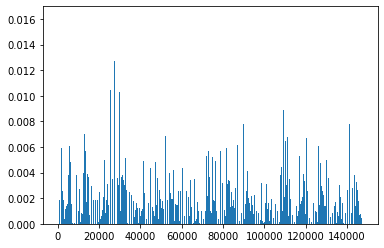

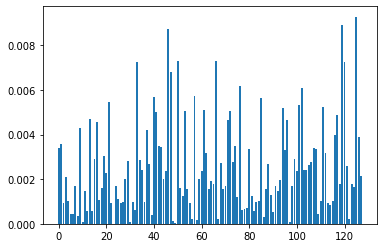

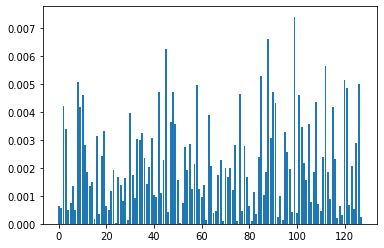

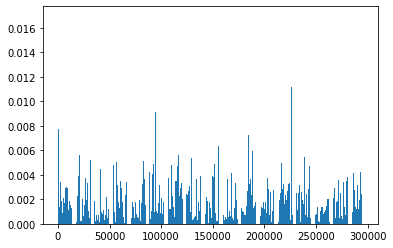

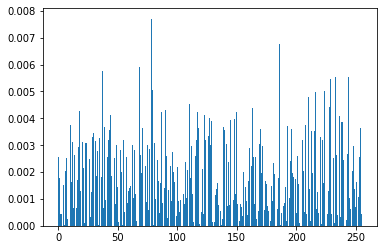

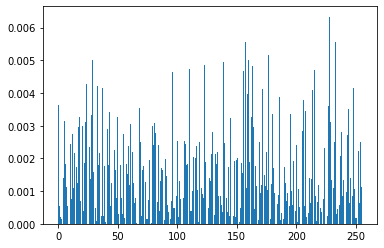

In [ ]:
for p, o in zip(model.parameters(), orig.parameters()):
    l = p-o
    plt.figure()
    height = t.abs(l).flatten().detach().cpu().numpy()
    xaxis = list(range(len(height)))
    plt.bar(xaxis, height)
    plt.show()

# PowerSGD

In [25]:
def power_sgd(model, Q):
    for p, q in zip(model.parameters(), Q):
        if type(q)!=bool:
            print(p.shape, q.shape)
        else:
            print(p.shape, False)

In [26]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xb_train, yb_train = [], []
xb_test, yb_test =[], []
print('epoch \t val_loss \t val_acc \t train_acc')

Q = []
r = 1
for p in model.parameters():
    if len(p.size()) > 1:
        m = p.reshape(p.size(0), -1).size(1)
        Q.append(t.normal(1.0, 1.0, size=(m, r)))
    else:
        Q.append(False)
        

for _ in tqdm(range(1, epochs+1), leave=False):
    xb_train.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        power_sgd(model, Q)
        hello += 1
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yb_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xb_train[-1], loss_val.item(), yb_test[-1], yb_train[-1],
    ))

epoch 	 val_loss 	 val_acc 	 train_acc


torch.Size([64, 1, 7, 7]) torch.Size([49, 1])
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) torch.Size([576, 1])
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) torch.Size([576, 1])
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) torch.Size([576, 1])
torch.Size([64]) False
torch.Size([64]) False
torch.Size([64, 64, 3, 3]) torch.Size([576, 1])
torch.Size([64]) False
torch.Size([64]) False
torch.Size([128, 64, 3, 3]) torch.Size([576, 1])
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) torch.Size([1152, 1])
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 64, 1, 1]) torch.Size([64, 1])
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) torch.Size([1152, 1])
torch.Size([128]) False
torch.Size([128]) False
torch.Size([128, 128, 3, 3]) torch.Size([1152, 1])
torch.Size([128]) False
torch.Size([128]) False
torch.Size([256, 128, 3, 3]) torch.Size([1

NameError: name 'hello' is not defined

# gradient approximation using all directions

In [ ]:
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xa_train, ya_train = [], []
xa_test, ya_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xa_train.append(_)
    xa_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(model, sdirs, device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ya_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ya_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xa_train[-1], loss_val.item(), ya_train[-1], ya_test[-1]
    ))

# gradient approximation using n directions

In [ ]:
n = 1
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xe_train, ye_train = [], []
xe_test, ye_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xe_train.append(_)
    xe_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[_] for _ in np.random.randint(0, len(sdirs), size=(n,))], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    ye_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xe_train[-1], loss_val.item(), ye_train[-1], ye_test[-1]
    ))

In [ ]:
n = 10
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xc_train, yc_train = [], []
xc_test, yc_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xc_train.append(_)
    xc_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[_] for _ in np.random.randint(0, len(sdirs), size=(n,))], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yc_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xc_train[-1], loss_val.item(), yc_train[-1], yc_test[-1]
    ))

In [ ]:
n = 100
model = resnet.resnet18(num_channels=1, num_classes=output_size).to(device)
model.load_state_dict(t.load('../ckpts/init/{}_resnet18.init'.format(dataset)))

xd_train, yd_train = [], []
xd_test, yd_test = [], []
for _ in tqdm(range(1, epochs+1), leave=False):
    start = time.time()
    xd_train.append(_)
    xd_test.append(_)
    correcti = 0
    for idx, (data, labels) in enumerate(trainloader):
        x, y = data.to(device), labels.to(device)
        optimizer = t.optim.SGD(model.parameters(), lr=lr)
        optimizer.zero_grad()
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        loss_val.backward()
        _, error = gradient_approximation(
            model, 
            [sdirs[_] for _ in np.random.randint(0, len(sdirs), size=(n,))], device, [])
        optimizer.step()
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_train.append(correcti/len(trainloader.dataset))
    
    correcti = 0
    for idx, (data, labels) in enumerate(testloader):
        x, y = data.to(device), labels.to(device)
        y_hat = model(x)
        loss_val = loss(y_hat, y)
        predi = y_hat.argmax(1, keepdim=True)
        correcti += predi.eq(y.view_as(predi)).sum().item()
    yd_test.append(correcti/len(testloader.dataset))
    print('{} \t {:.4f} \t {:.2f} \t {:.2f}'.format(
        xd_train[-1], loss_val.item(), yd_train[-1], yd_test[-1]
    ))

In [ ]:
plt.figure()
plt.plot([x_test]+xb_train, [y_test]+yb_test, label='SGD', c='r')
# plt.plot([x_test]+xa_train, [y_test]+ya_test, label='SGD {}-approx.'.format(len(sdirs)), c='b')
plt.plot([x_test]+xc_train, [y_test]+yc_test, label='SGD 10-approx.', c='g')
plt.plot([x_test]+xd_train, [y_test]+yd_test, label='SGD 100-approx.', c='k')
plt.plot([x_test]+xe_train, [y_test]+ye_test, label='SGD 1-approx.', c='c')

history = {
    'test': [x_test, y_test],
#     'a': [xa_train, ya_train, xa_test, ya_test],
    'b': [xb_train, yb_train, xb_test, yb_test],
    'c': [xc_train, yc_train, xc_test, yc_test],
    'd': [xd_train, yd_train, xd_test, yd_test],
    'e': [xe_train, ye_train, xe_test, ye_test],
}

name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_proj_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(name)

pkl.dump(history, open('../ckpts/history/{}.pkl'.format(name), 'wb'))

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(
    '../ckpts/plots/{}.png'.format(name), 
    dpi=300, bbox_inches='tight'
)

# Comparisons

In [ ]:
name = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_random_proj_sampling'.format(
    'resnet18', dataset, sdirs_algo, bs)

history = pkl.load(open('../ckpts/history/{}.pkl'.format(name), 'rb'))
h = pkl.load(open('../ckpts/history/{}.pkl'.format(name.replace('proj', 'grad')), 'rb'))

plt.figure()
plt.plot([history['test'][0]]+history['b'][0], [history['test'][1]]+history['b'][-1],
         label='SGD', c='r')
plt.plot([history['test'][0]]+history['d'][0], [history['test'][1]]+history['d'][-1], 
         label='SGD 100-random.', c='k', linestyle='--')
plt.plot([h['test'][0]]+h['d'][0], [h['test'][1]]+h['d'][-1], label='SGD 100-grad.', c='k')
plt.plot([history['test'][0]]+history['c'][0], [history['test'][1]]+history['c'][-1], 
         label='SGD 10-random.', c='g', linestyle='--')
plt.plot([h['test'][0]]+h['c'][0], [h['test'][1]]+h['c'][-1], label='SGD 10-grad.', c='g')
plt.plot([history['test'][0]]+history['e'][0], [history['test'][1]]+history['e'][-1], 
         label='SGD 1-random.', c='c', linestyle='--')
plt.plot([h['test'][0]]+h['e'][0], [h['test'][1]]+h['e'][-1], label='SGD 1-grad.', c='c')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
cname = 'clf_{}_{}_algo_{}_bs_{}_sgd_vs_sgd_approx_comparison'.format(
    'resnet18', dataset, sdirs_algo, bs)
print(cname)
plt.savefig(
    '../ckpts/plots/{}.png'.format(cname), 
    dpi=300, bbox_inches='tight'
)